여드름 감지 서비스 모델 (PyTorch, EfficientNet-b0기반)

In [10]:
# 1. 라이브러리 임포트
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import shutil

In [11]:
# 2. GPU 또는 CPU 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [12]:
# 3. 데이터 경로 설정 (로컬 환경)
BASE_DIR = os.path.join(os.getcwd(), "resized")
IMG_DIR = BASE_DIR
CLASS_DIRS = {
    "normal": os.path.join(BASE_DIR, "normal"),
    "mild": os.path.join(BASE_DIR, "mild"),
    "moderate": os.path.join(BASE_DIR, "moderate"),
    "severe": os.path.join(BASE_DIR, "severe"),
    "very_severe": os.path.join(BASE_DIR, "very_severe")
}
CLASS_ID_MAP = {"normal": 0, "mild": 1, "moderate": 2, "severe": 3, "very_severe": 4}
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
NUM_CLASSES = 5
EPOCHS = 20
BATCH_SIZE = 8  # ResNet-50용, 메모리 절약

In [13]:
# 데이터 분할 폴더
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [14]:
# 4. 데이터 전처리: CSV 생성
def is_image(p):
    return os.path.isfile(p) and p.lower().endswith(IMG_EXTS)

rows = []
for label_name, class_dir in CLASS_DIRS.items():
    if os.path.isdir(class_dir):
        class_files = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True) if is_image(p)]
        print(f"[DEBUG] {label_name} files found: {len(class_files)}")
        for fp in class_files:
            rows.append([fp, label_name, CLASS_ID_MAP[label_name]])
    else:
        print(f"[WARN] {label_name} directory not found: {class_dir}")

df = pd.DataFrame(rows, columns=["filepath", "label_name", "label_id"])
out_csv = os.path.join(BASE_DIR, "labels_total.csv")
df.to_csv(out_csv, index=False)
print(f"CSV 생성 완료: {out_csv}")
print("Label distribution:\n", df["label_name"].value_counts())

[DEBUG] normal files found: 936
[DEBUG] mild files found: 359
[DEBUG] moderate files found: 95
[DEBUG] severe files found: 128
[DEBUG] very_severe files found: 90
CSV 생성 완료: c:\Users\Admin\work space\2nd\resized\labels_total.csv
Label distribution:
 label_name
normal         936
mild           359
severe         128
moderate        95
very_severe     90
Name: count, dtype: int64


In [15]:
# 5. 데이터 분할 및 밸런싱
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label_name"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1765, stratify=train_df["label_name"], random_state=42)
print("Test dataset class distribution:\n", test_df["label_name"].value_counts())

targets = {"normal": 1000, "mild": 800, "moderate": 800, "severe": 800, "very_severe": 800}
def make_balanced(df, targets):
    rng = np.random.default_rng(42)
    outs = []
    for lab, n in targets.items():
        sub = df[df["label_name"] == lab]
        if len(sub) >= n:
            outs.append(sub.sample(n=n, random_state=42))
        else:
            idx = rng.choice(sub.index.to_numpy(), size=n, replace=True)
            outs.append(df.loc[idx])
    return pd.concat(outs, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

train_bal = make_balanced(train_df, targets)
train_bal.to_csv(os.path.join(BASE_DIR, "split_train.balanced.csv"), index=False)
val_df.to_csv(os.path.join(BASE_DIR, "split_val.csv"), index=False)
test_df.to_csv(os.path.join(BASE_DIR, "split_test.csv"), index=False)
print("Train:\n", train_bal["label_name"].value_counts())
print("Val:\n", val_df["label_name"].value_counts())
print("Test:\n", test_df["label_name"].value_counts())

Test dataset class distribution:
 label_name
normal         141
mild            54
severe          19
very_severe     14
moderate        14
Name: count, dtype: int64
Train:
 label_name
normal         1000
mild            800
moderate        800
severe          800
very_severe     800
Name: count, dtype: int64
Val:
 label_name
normal         141
mild            54
severe          19
very_severe     14
moderate        14
Name: count, dtype: int64
Test:
 label_name
normal         141
mild            54
severe          19
very_severe     14
moderate        14
Name: count, dtype: int64


In [16]:
# 폴더 구조 생성
def organize_folders(csv_df, dest_folder):
    for _, row in csv_df.iterrows():
        label = row['label_name']
        src_path = row['filepath']
        dest_label_dir = os.path.join(dest_folder, label)
        os.makedirs(dest_label_dir, exist_ok=True)
        dest_path = os.path.join(dest_label_dir, os.path.basename(src_path))
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

organize_folders(train_bal, train_dir)
organize_folders(val_df, val_dir)
organize_folders(test_df, test_dir)
print("폴더 구조 생성 완료!")

폴더 구조 생성 완료!


In [17]:
# 6. 데이터 로딩: transforms와 DataLoader
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print("클래스 매핑:", train_dataset.class_to_idx)

클래스 매핑: {'mild': 0, 'moderate': 1, 'normal': 2, 'severe': 3, 'very_severe': 4}


In [18]:
import torch
import torch.nn as nn
from torchvision import models

class AcneClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(AcneClassifier, self).__init__()
        # EfficientNet-B0 모델 로드 (pretrained=True로 ImageNet 가중치 사용)
        self.model = models.efficientnet_b0(pretrained=True)
        
        # 초기 레이어 동결
        for param in self.model.parameters():
            param.requires_grad = False
        
        # features의 후반 레이어 해제 (마지막 4개 블록: features[5] ~ features[8])
        num_blocks = len(self.model.features)  # features의 총 블록 수 (9개)
        for i in range(max(0, num_blocks - 4), num_blocks):  # 마지막 4개 블록 해제
            for param in self.model.features[i].parameters():
                param.requires_grad = True
        
        # classifier 부분 전체 해제
        for param in self.model.classifier.parameters():
            param.requires_grad = True
        
        # 출력 레이어 수정: ImageNet 1000 클래스 -> 5 클래스
        num_ftrs = self.model.classifier[1].in_features  # EfficientNet-B0의 classifier 입력 크기 (1280)
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),  # Dropout 비율 0.2로 설정
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# 모델 인스턴스 생성
model = AcneClassifier(num_classes=NUM_CLASSES)
model.to(DEVICE)
print("EfficientNet-B0 모델 로드 완료! 총 매개변수:", sum(p.numel() for p in model.parameters()))

EfficientNet-B0 모델 로드 완료! 총 매개변수: 4013953


c:\Users\Admin\miniconda3\envs\project\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\miniconda3\envs\project\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
# 8. 학습 설정
class_counts = train_bal["label_name"].value_counts()
weights = torch.tensor([1.0 / class_counts[cls] for cls in CLASS_ID_MAP.keys()], dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.00003)  # ResNet-50용 낮은 학습률
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# 조기 종료 설정
patience = 5
best_val_loss = float('inf')
counter = 0
best_model_path = os.path.join(BASE_DIR, 'best_acne_model.pth')

In [20]:
# 9. 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 조기 종료
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with Val Loss: {best_val_loss:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_loss)

Epoch 1/20: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]


Epoch 1/20 - Train Loss: 1.1234, Train Acc: 0.6500, Val Loss: 0.6858, Val Acc: 0.8264
Best model saved with Val Loss: 0.6858


Epoch 2/20: 100%|██████████| 163/163 [01:13<00:00,  2.23it/s]


Epoch 2/20 - Train Loss: 0.6327, Train Acc: 0.7941, Val Loss: 0.4741, Val Acc: 0.8533
Best model saved with Val Loss: 0.4741


Epoch 3/20: 100%|██████████| 163/163 [01:14<00:00,  2.20it/s]


Epoch 3/20 - Train Loss: 0.4930, Train Acc: 0.8342, Val Loss: 0.3522, Val Acc: 0.8657
Best model saved with Val Loss: 0.3522


Epoch 4/20: 100%|██████████| 163/163 [01:12<00:00,  2.24it/s]


Epoch 4/20 - Train Loss: 0.4475, Train Acc: 0.8412, Val Loss: 0.2860, Val Acc: 0.9029
Best model saved with Val Loss: 0.2860


Epoch 5/20: 100%|██████████| 163/163 [01:29<00:00,  1.83it/s]


Epoch 5/20 - Train Loss: 0.4044, Train Acc: 0.8558, Val Loss: 0.2642, Val Acc: 0.9256
Best model saved with Val Loss: 0.2642


Epoch 6/20: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]


Epoch 6/20 - Train Loss: 0.3763, Train Acc: 0.8689, Val Loss: 0.2220, Val Acc: 0.9360
Best model saved with Val Loss: 0.2220


Epoch 7/20: 100%|██████████| 163/163 [01:12<00:00,  2.23it/s]


Epoch 7/20 - Train Loss: 0.3426, Train Acc: 0.8751, Val Loss: 0.1883, Val Acc: 0.9298
Best model saved with Val Loss: 0.1883


Epoch 8/20: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]


Epoch 8/20 - Train Loss: 0.3427, Train Acc: 0.8843, Val Loss: 0.1732, Val Acc: 0.9277
Best model saved with Val Loss: 0.1732


Epoch 9/20: 100%|██████████| 163/163 [01:10<00:00,  2.30it/s]


Epoch 9/20 - Train Loss: 0.2812, Train Acc: 0.8959, Val Loss: 0.1725, Val Acc: 0.9545
Best model saved with Val Loss: 0.1725


Epoch 10/20: 100%|██████████| 163/163 [02:21<00:00,  1.15it/s]


Epoch 10/20 - Train Loss: 0.2848, Train Acc: 0.9005, Val Loss: 0.1491, Val Acc: 0.9380
Best model saved with Val Loss: 0.1491


Epoch 11/20: 100%|██████████| 163/163 [01:53<00:00,  1.44it/s]


Epoch 11/20 - Train Loss: 0.2651, Train Acc: 0.9013, Val Loss: 0.1194, Val Acc: 0.9525
Best model saved with Val Loss: 0.1194


Epoch 12/20: 100%|██████████| 163/163 [02:00<00:00,  1.35it/s]


Epoch 12/20 - Train Loss: 0.2525, Train Acc: 0.9036, Val Loss: 0.1187, Val Acc: 0.9690
Best model saved with Val Loss: 0.1187


Epoch 13/20: 100%|██████████| 163/163 [01:27<00:00,  1.86it/s]


Epoch 13/20 - Train Loss: 0.2480, Train Acc: 0.9121, Val Loss: 0.1110, Val Acc: 0.9731
Best model saved with Val Loss: 0.1110


Epoch 14/20: 100%|██████████| 163/163 [01:47<00:00,  1.52it/s]


Epoch 14/20 - Train Loss: 0.2254, Train Acc: 0.9190, Val Loss: 0.0952, Val Acc: 0.9773
Best model saved with Val Loss: 0.0952


Epoch 15/20: 100%|██████████| 163/163 [01:27<00:00,  1.86it/s]


Epoch 15/20 - Train Loss: 0.2228, Train Acc: 0.9244, Val Loss: 0.0882, Val Acc: 0.9793
Best model saved with Val Loss: 0.0882


Epoch 16/20: 100%|██████████| 163/163 [02:00<00:00,  1.35it/s]


Epoch 16/20 - Train Loss: 0.2104, Train Acc: 0.9306, Val Loss: 0.0687, Val Acc: 0.9814
Best model saved with Val Loss: 0.0687


Epoch 17/20: 100%|██████████| 163/163 [02:19<00:00,  1.17it/s]


Epoch 17/20 - Train Loss: 0.2029, Train Acc: 0.9291, Val Loss: 0.0641, Val Acc: 0.9876
Best model saved with Val Loss: 0.0641


Epoch 18/20: 100%|██████████| 163/163 [02:16<00:00,  1.20it/s]


Epoch 18/20 - Train Loss: 0.1977, Train Acc: 0.9368, Val Loss: 0.0502, Val Acc: 0.9876
Best model saved with Val Loss: 0.0502


Epoch 19/20: 100%|██████████| 163/163 [02:03<00:00,  1.32it/s]


Epoch 19/20 - Train Loss: 0.1939, Train Acc: 0.9337, Val Loss: 0.0507, Val Acc: 0.9876


Epoch 20/20: 100%|██████████| 163/163 [02:31<00:00,  1.08it/s]


Epoch 20/20 - Train Loss: 0.1671, Train Acc: 0.9483, Val Loss: 0.0457, Val Acc: 0.9897
Best model saved with Val Loss: 0.0457


In [21]:
# 10. 모델 저장
torch.save(model.state_dict(), os.path.join(BASE_DIR, 'acne_model.pth'))
print("모델 저장 완료!")

모델 저장 완료!


In [22]:
# 11. 테스트 및 평가
model.load_state_dict(torch.load(best_model_path))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 예측된 클래스 확인
unique_preds = np.unique(y_pred)
print("Predicted classes:", [list(CLASS_ID_MAP.keys())[i] for i in unique_preds])

Predicted classes: ['normal', 'mild', 'moderate', 'severe', 'very_severe']


In [23]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(CLASS_ID_MAP.keys()), zero_division=0))


Classification Report:
              precision    recall  f1-score   support

      normal       0.96      0.98      0.97        54
        mild       0.92      0.86      0.89        14
    moderate       1.00      1.00      1.00       141
      severe       0.78      0.74      0.76        19
 very_severe       0.73      0.79      0.76        14

    accuracy                           0.95       242
   macro avg       0.88      0.87      0.88       242
weighted avg       0.95      0.95      0.95       242



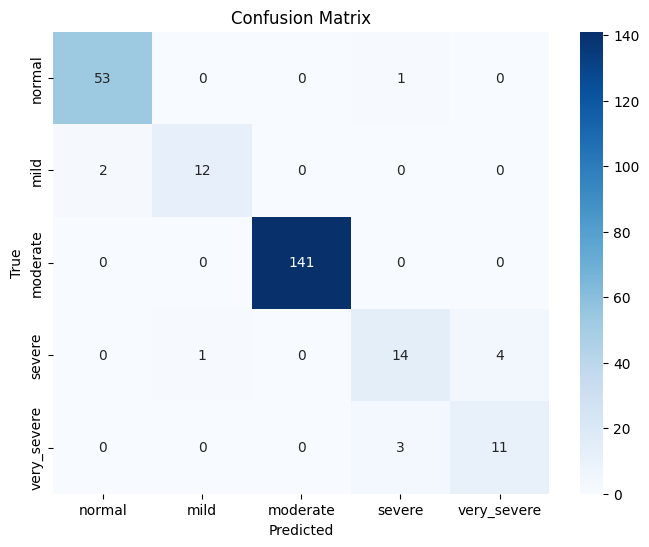

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(CLASS_ID_MAP.keys()), yticklabels=list(CLASS_ID_MAP.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

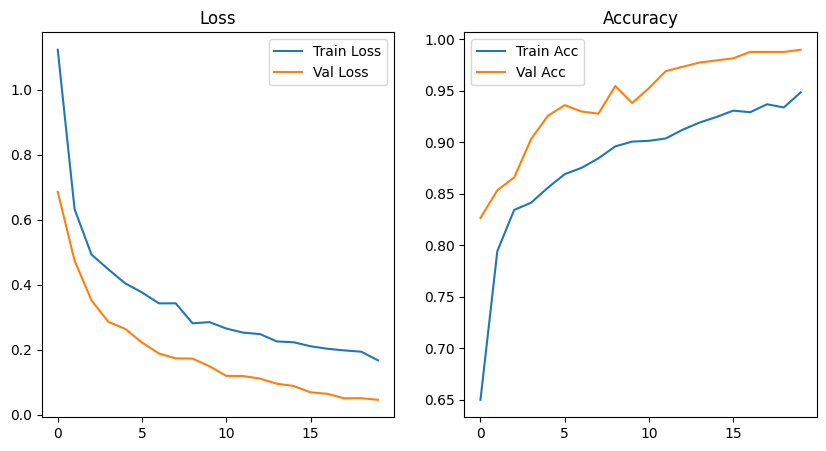

In [25]:
# 12. 손실 및 정확도 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()